In [5]:
%pip install pandas
%pip install seaborn

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib
import re

Matplotlib is building the font cache; this may take a moment.


In [7]:
train_test="train_data.txt"
train_data = []
with open(train_test, "r") as file:
    for line in file:
        parts = line.strip().split(" ::: ")
        if len(parts) == 4:
            train_data.append(parts)

df_train = pd.DataFrame(train_data, columns=["ID", "Title_Year", "Genre", "Plot"])
df_train.head()


,ID,Title_Year,Genre,Plot
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [8]:
print(df_train.isnull().sum())
print(df_train.nunique())

ID            0
Title_Year    0
Genre         0
Plot          0
dtype: int64
ID            54214
Title_Year    54214
Genre            27
Plot          54086
dtype: int64


In [9]:
df_train = df_train.drop(columns=["ID", "Title_Year"])

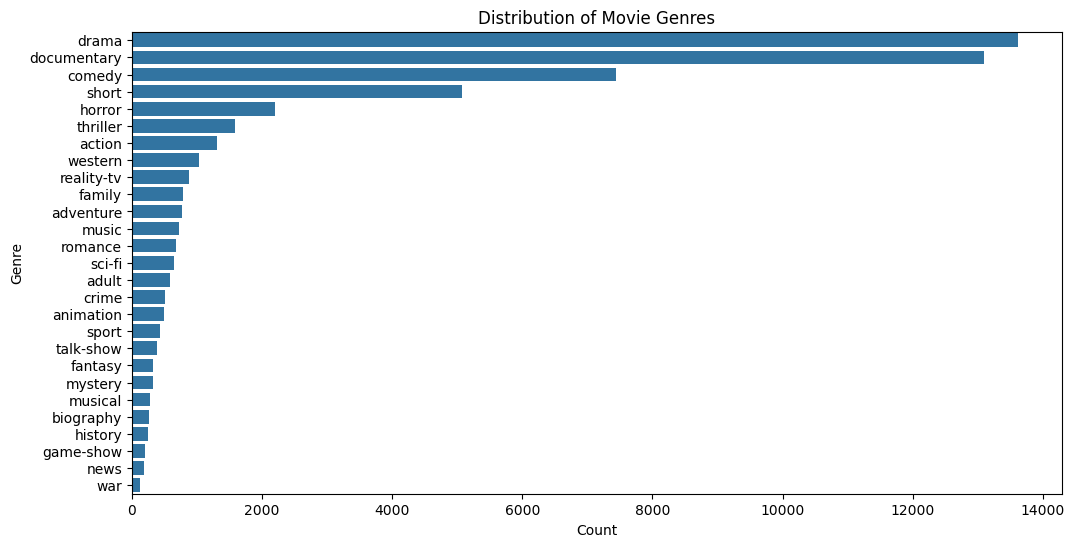

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(y=df_train["Genre"], order=df_train["Genre"].value_counts().index)
plt.title("Distribution of Movie Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


In [11]:
train_test="test_data.txt"
with open(train_test, "r") as files:

    test_lines = []
    for line in files:
        parts = line.strip().split(" ::: ")
        if len(parts) == 3:
            movie_id, title, description = parts
            test_data.append((movie_id, title, description))

# Create DataFrames
df_test = pd.DataFrame(test_data, columns=["ID", "Title", "Plot"])

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df_train["Plot"], df_train["Genre"], test_size=0.2, random_state=42)

# Define a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

# Transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(df_test["Plot"])  # Transform test data

# Train Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_acc = accuracy_score(y_val, nb_model.predict(X_val_tfidf))

# Train Logistic Regression Model
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_tfidf, y_train)
lr_acc = accuracy_score(y_val, lr_model.predict(X_val_tfidf))

# Train SVM Model
svm_model = SVC(kernel="linear")
svm_model.fit(X_train_tfidf, y_train)
svm_acc = accuracy_score(y_val, svm_model.predict(X_val_tfidf))

# Compare model performance
model_scores = {
    "Naive Bayes": nb_acc,
    "Logistic Regression": lr_acc,
    "SVM": svm_acc
}
best_model_name = max(model_scores, key=model_scores.get)
print(f"Best Model: {best_model_name} with Accuracy: {model_scores[best_model_name]:.2f}")

# Select the best model
best_model = {"Naive Bayes": nb_model, "Logistic Regression": lr_model, "SVM": svm_model}[best_model_name]


Best Model: SVM with Accuracy: 0.59


In [13]:

# Save the best model and vectorizer
joblib.dump(best_model, "best_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("Best model and vectorizer saved successfully!")

# Load model for testing
best_model = joblib.load("best_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Transform test data using the same vectorizer
X_test_tfidf = vectorizer.transform(df_test["Plot"])

# Predict genres on test set
df_test["Predicted Genre"] = best_model.predict(X_test_tfidf)

# Save predictions
df_test[["Title", "Predicted Genre"]].to_csv("test_predictions.csv", index=False)
print("Predictions saved to 'test_predictions.csv'!")

# Display results
print(df_test[["Title", "Predicted Genre"]])


Best model and vectorizer saved successfully!
Predictions saved to 'test_predictions.csv'!
                                 Title Predicted Genre
0                 Edgar's Lunch (1998)          comedy
1             La guerra de papá (1977)           drama
2          Off the Beaten Track (2010)     documentary
3               Meu Amigo Hindu (2015)           drama
4                    Er nu zhai (1955)           drama
...                                ...             ...
108395  "Tales of Light & Dark" (2013)           drama
108396     Der letzte Mohikaner (1965)          action
108397             Oliver Twink (2007)          comedy
108398               Slipstream (1973)          comedy
108399       Curitiba Zero Grau (2010)     documentary

[108400 rows x 2 columns]
